In [8]:
# !pip install pandas

In [9]:
import pandas as pd

In [10]:
df = pd.read_csv('data/ner_dataset.csv', encoding = "ISO-8859-1")
# df = df[:10000]
df = df.fillna(method='ffill')
df.head()

/tmp/ipykernel_6778/1909696286.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [11]:
df.groupby('Tag').size().reset_index(name='Counts')

,Tag,Counts
0,B-art,402
1,B-eve,308
2,B-geo,37644
3,B-gpe,15870
4,B-nat,201
5,B-org,20143
6,B-per,16990
7,B-tim,20333
8,I-art,297
9,I-eve,253


In [12]:
# display percentages of each tag
df.groupby('Tag').size().div(len(df)).reset_index(name='Percentage')

,Tag,Percentage
0,B-art,0.000383
1,B-eve,0.000294
2,B-geo,0.035900
3,B-gpe,0.015135
4,B-nat,0.000192
5,B-org,0.019210
6,B-per,0.016203
7,B-tim,0.019391
8,I-art,0.000283
9,I-eve,0.000241


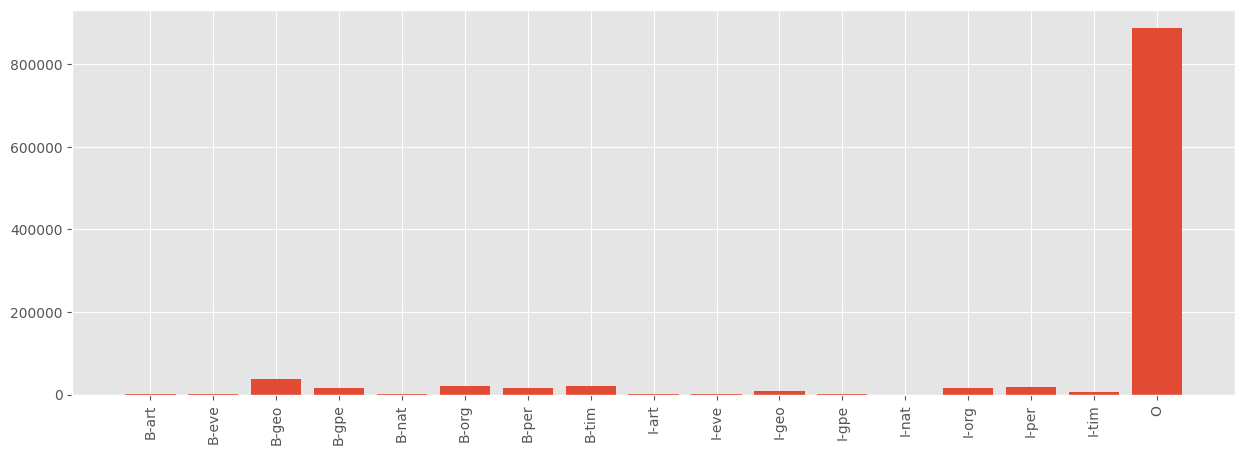

In [13]:
# plot the counts for each tag
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure(figsize=(15, 5))
plt.bar(df.groupby('Tag').size().reset_index(name='Counts')['Tag'], df.groupby('Tag').size().reset_index(name='Counts')['Counts'])
plt.xticks(rotation=90)
plt.show()


In [14]:
def collate(dataframe):
    agg_func = lambda s: [(w, pos, t) for w, pos, t in zip(s['Word'].values.tolist(), s['POS'].values.tolist(), s['Tag'].values.tolist())]
    grouped = dataframe.groupby('Sentence #').apply(agg_func)
    return list(grouped)

print("--- original dataframe:\n")
print(df)
sentences = collate(df)
print("\n--- number of sentences: {}\n".format(len(sentences)))
sentences[0:2]

--- original dataframe:

              Sentence #           Word  POS Tag
0            Sentence: 1      Thousands  NNS   O
1            Sentence: 1             of   IN   O
2            Sentence: 1  demonstrators  NNS   O
3            Sentence: 1           have  VBP   O
4            Sentence: 1        marched  VBN   O
...                  ...            ...  ...  ..
1048570  Sentence: 47959           they  PRP   O
1048571  Sentence: 47959      responded  VBD   O
1048572  Sentence: 47959             to   TO   O
1048573  Sentence: 47959            the   DT   O
1048574  Sentence: 47959         attack   NN   O

[1048575 rows x 4 columns]

--- number of sentences: 47959



[[('Thousands', 'NNS', 'O'),
  ('of', 'IN', 'O'),
  ('demonstrators', 'NNS', 'O'),
  ('have', 'VBP', 'O'),
  ('marched', 'VBN', 'O'),
  ('through', 'IN', 'O'),
  ('London', 'NNP', 'B-geo'),
  ('to', 'TO', 'O'),
  ('protest', 'VB', 'O'),
  ('the', 'DT', 'O'),
  ('war', 'NN', 'O'),
  ('in', 'IN', 'O'),
  ('Iraq', 'NNP', 'B-geo'),
  ('and', 'CC', 'O'),
  ('demand', 'VB', 'O'),
  ('the', 'DT', 'O'),
  ('withdrawal', 'NN', 'O'),
  ('of', 'IN', 'O'),
  ('British', 'JJ', 'B-gpe'),
  ('troops', 'NNS', 'O'),
  ('from', 'IN', 'O'),
  ('that', 'DT', 'O'),
  ('country', 'NN', 'O'),
  ('.', '.', 'O')],
 [('Iranian', 'JJ', 'B-gpe'),
  ('officials', 'NNS', 'O'),
  ('say', 'VBP', 'O'),
  ('they', 'PRP', 'O'),
  ('expect', 'VBP', 'O'),
  ('to', 'TO', 'O'),
  ('get', 'VB', 'O'),
  ('access', 'NN', 'O'),
  ('to', 'TO', 'O'),
  ('sealed', 'JJ', 'O'),
  ('sensitive', 'JJ', 'O'),
  ('parts', 'NNS', 'O'),
  ('of', 'IN', 'O'),
  ('the', 'DT', 'O'),
  ('plant', 'NN', 'O'),
  ('Wednesday', 'NNP', 'B-tim'),
  ('

In [15]:
# !pip install scikit-learn
# !pip install git+https://github.com/MeMartijn/updated-sklearn-crfsuite.git#egg=sklearn_crfsuite

In [16]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {
        'word.lower()': word.lower(),  # the word in lowercase
        'word[-3:]': word[-3:],  # last three characters
        'word[-2:]': word[-2:],  # last two characters
        'word.isupper()': word.isupper(),  # true, if the word is in uppercase
        'word.istitle()': word.istitle(),  # true, if the first character is in uppercase and remaining characters are in lowercase
        'word.isdigit()': word.isdigit(),  # true, if all characters are digits
        'postag': postag,  # POS tag
        'postag[:2]': postag[:2],  # IOB prefix
    }
    
    if i > 0:
        word1 = sent[i-1][0]  # the previous word
        postag1 = sent[i-1][1]  # POS tag of the previous word
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })  # add some features of the previous word
    else:
        features['BOS'] = True  # BOS: begining of the sentence
        
    if i < len(sent)-1:
        word1 = sent[i+1][0]  # the next word
        postag1 = sent[i+1][1]  # POS tag of the next word
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })  # add some features of the next word
    else:
        features['EOS'] = True  # EOS: end of the sentence
    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for _, _, label in sent]

In [26]:
from sklearn.model_selection import train_test_split

X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)


In [27]:
# Store original sequence lengths
original_lengths = [len(seq) for seq in y_train]

# Flatten y_train
y_train_flat = [label for sublist in y_train for label in sublist]

# Flatten X_train
X_train_dicts = [d for sublist in X_train for d in sublist]
X_train_df = pd.DataFrame(X_train_dicts)



In [22]:
# from sklearn.preprocessing import MultiLabelBinarizer

# # Flatten y_train
# y_train_flat = [label for sublist in y_train for label in sublist]

# # Flatten X_train
# X_train_dicts = [d for sublist in X_train for d in sublist]
# X_train_df = pd.DataFrame(X_train_dicts)

In [29]:
from imblearn.under_sampling import RandomUnderSampler

# Apply RandomUnderSampler
rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_resample(X_train_df, y_train_flat)

# Convert back to original sequence format for y
y_train_resampled = []
start_idx = 0
for length in original_lengths:
    end_idx = start_idx + length
    y_train_resampled.append(y_resampled[start_idx:end_idx])
    start_idx = end_idx

# Convert back to original sequence format for X
X_train_resampled = []
start_idx = 0
for length in original_lengths:
    end_idx = start_idx + length
    X_train_resampled.append(X_resampled[start_idx:end_idx].to_dict(orient='records'))
    start_idx = end_idx

In [34]:
X_train_resampled

[[{'word.lower()': 'su-24',
   'word[-3:]': '-24',
   'word[-2:]': '24',
   'word.isupper()': False,
   'word.istitle()': True,
   'word.isdigit()': False,
   'postag': 'NNP',
   'postag[:2]': 'NN',
   'BOS': nan,
   '+1:word.lower()': 'bombers',
   '+1:word.istitle()': False,
   '+1:word.isupper()': False,
   '+1:postag': 'NNS',
   '+1:postag[:2]': 'NN',
   '-1:word.lower()': 'of',
   '-1:word.istitle()': False,
   '-1:word.isupper()': False,
   '-1:postag': 'IN',
   '-1:postag[:2]': 'IN',
   'EOS': nan},
  {'word.lower()': 'cy',
   'word[-3:]': 'Cy',
   'word[-2:]': 'Cy',
   'word.isupper()': False,
   'word.istitle()': True,
   'word.isdigit()': False,
   'postag': 'NNP',
   'postag[:2]': 'NN',
   'BOS': nan,
   '+1:word.lower()': 'young',
   '+1:word.istitle()': True,
   '+1:word.isupper()': False,
   '+1:postag': 'NNP',
   '+1:postag[:2]': 'NN',
   '-1:word.lower()': 'the',
   '-1:word.istitle()': False,
   '-1:word.isupper()': False,
   '-1:postag': 'DT',
   '-1:postag[:2]': 'DT'

In [33]:
y_train_resampled

[['B-art',
  'B-art',
  'B-art',
  'B-art',
  'B-art',
  'B-art',
  'B-art',
  'B-art',
  'B-art',
  'B-art',
  'B-art',
  'B-art',
  'B-art',
  'B-art',
  'B-art',
  'B-art',
  'B-art',
  'B-art',
  'B-art',
  'B-art',
  'B-art',
  'B-art',
  'B-art',
  'B-art'],
 ['B-art', 'B-art', 'B-art', 'B-art', 'B-eve', 'B-eve', 'B-eve', 'B-eve'],
 ['B-eve',
  'B-eve',
  'B-eve',
  'B-eve',
  'B-eve',
  'B-eve',
  'B-eve',
  'B-eve',
  'B-eve',
  'B-eve',
  'B-eve',
  'B-eve',
  'B-eve',
  'B-eve',
  'B-eve',
  'B-eve',
  'B-eve',
  'B-eve',
  'B-eve',
  'B-eve',
  'B-eve',
  'B-eve',
  'B-eve',
  'B-eve',
  'B-geo',
  'B-geo',
  'B-geo',
  'B-geo',
  'B-geo',
  'B-geo',
  'B-geo',
  'B-geo'],
 ['B-geo',
  'B-geo',
  'B-geo',
  'B-geo',
  'B-geo',
  'B-geo',
  'B-geo',
  'B-geo',
  'B-geo',
  'B-geo',
  'B-geo',
  'B-geo',
  'B-geo',
  'B-geo',
  'B-geo',
  'B-geo',
  'B-geo',
  'B-geo',
  'B-geo',
  'B-geo',
  'B-gpe'],
 ['B-gpe',
  'B-gpe',
  'B-gpe',
  'B-gpe',
  'B-gpe',
  'B-gpe',
  'B-gpe'

In [36]:
# plot the counts for each tag
import matplotlib.pyplot as plt


plt.style.use("ggplot")
plt.figure(figsize=(15, 5))
plt.hist(y_train_resampled, bins=[0, 1, 2, 3, 4, 5]);
plt.xticks(rotation=90)
plt.show()

KeyboardInterrupt: 

In [107]:
# !pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
  Using cached imbalanced_learn-0.11.0-py3-none-any.whl (235 kB)


In [98]:
%%time

import sklearn_crfsuite

crf = sklearn_crfsuite.CRF(
    algorithm='l2sgd',  # l2sgd: Stochastic Gradient Descent with L2 regularization term
    max_iterations=1000,  # maximum number of iterations
    
)

crf.fit(X_train, y_train)

CPU times: user 1.3 s, sys: 0 ns, total: 1.3 s
Wall time: 1.29 s


CRF(algorithm='l2sgd', max_iterations=1000)

In [99]:
# !pip install seaborn

              precision    recall  f1-score   support

           B       0.97      0.95      0.96       336
           I       0.99      0.92      0.95       156
           O       0.99      1.00      0.99      2884

    accuracy                           0.99      3376
   macro avg       0.98      0.96      0.97      3376
weighted avg       0.99      0.99      0.99      3376

Accuracy: 0.9899289099526066 for ['B' 'I' 'O']
              precision    recall  f1-score   support

       B-art       0.67      0.40      0.50         5
       B-eve       0.00      0.00      0.00         2
       B-geo       0.70      0.71      0.71        77
       B-gpe       0.78      0.84      0.81        91
       B-nat       0.00      0.00      0.00         2
       B-org       0.77      0.68      0.72        53
       B-per       0.82      0.90      0.86        61
       B-tim       0.97      0.78      0.86        45
       I-art       0.00      0.00      0.00         4
       I-eve       0.00      0.

/home/liamt/Uni/Master/HS23/ATAI/speakeasy-python-client-library/speakeasy-python-client-library/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/liamt/Uni/Master/HS23/ATAI/speakeasy-python-client-library/speakeasy-python-client-library/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/liamt/Uni/Master/HS23/ATAI/speakeasy-python-client-library/speakeasy-python-client-library/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning

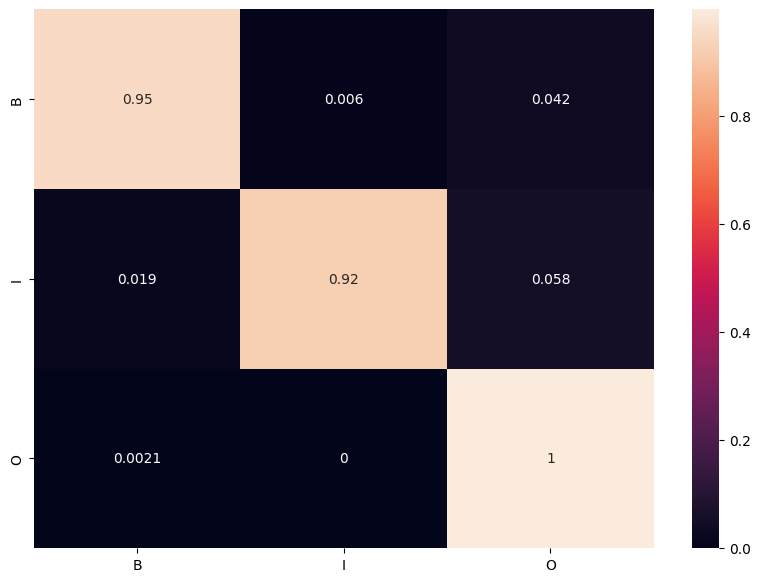

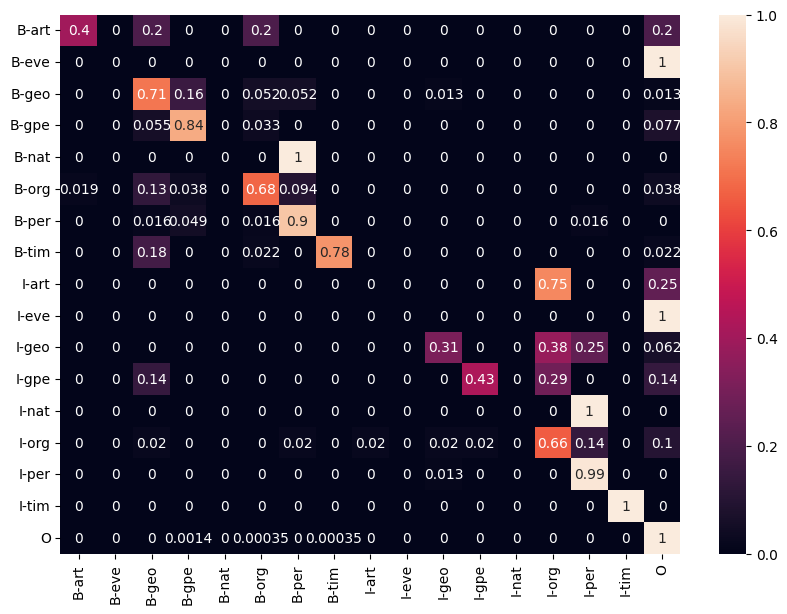

In [100]:
from itertools import chain
import numpy as np
import sklearn
import seaborn as sn


def confusion_matrix(y_true, y_pred, summarize_iob_tags=False):
    f_y_test = list(chain.from_iterable(y_test))
    f_y_pred = list(chain.from_iterable(y_pred))
    if summarize_iob_tags:
        # summarize IOB tags to only keep the first letter (eg. B-art -> B)
        f_y_test = [t[0] for t in f_y_test]
        f_y_pred = [t[0] for t in f_y_pred]

    labels = np.unique(f_y_test)
    print(sklearn.metrics.classification_report(f_y_test, f_y_pred))
    print(f"Accuracy: {sklearn.metrics.accuracy_score(f_y_test, f_y_pred)} for {labels}")

    cm = sklearn.metrics.confusion_matrix(f_y_test, f_y_pred, labels=labels)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, index = labels, columns = labels).fillna(0)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)

y_pred = crf.predict(X_test)

confusion_matrix(y_test, y_pred, summarize_iob_tags=True)
confusion_matrix(y_test, y_pred, summarize_iob_tags=False)

In [115]:
# predict tags of example sentence
question = "who is the director of Batman 1989"

y_pred = crf.predict([sent2features(question.split())])
print(y_pred)

[['O', 'O', 'O', 'O', 'O', 'B-gpe', 'I-gpe']]
